In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import datetime
import geopandas as gpd
from shapely.geometry import box
import rioxarray
import rasterio
import regionmask
from shapely.geometry import mapping
import os,glob
import rasterio.plot
import cdsapi
from pyproj import CRS

In [2]:
years=[]
for i in range(30):
    years.append(str(2022-i))
years.reverse()

In [3]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': '2m_temperature',
        'year': years,
        'month': ['06'
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '12:00'
        ],
        'area': [
            27, 88, 20,
            93,
        ],
    },
    r'Path to Directory\\BD_Temperature_data.nc')

2023-05-20 16:36:33,044 INFO Welcome to the CDS
2023-05-20 16:36:33,047 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-05-20 16:36:33,259 INFO Request is queued
2023-05-20 16:50:58,195 INFO Request is completed
2023-05-20 16:50:58,197 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.mars.internal-1684626606.8230495-22873-14-a44eef81-775c-429f-bd5f-1a863bb58f75.nc to C:\Users\skhan7\Desktop\Research\PhD\Chapter1\HPD_temperature\\BD_Ppt_data.nc (1.1M)
2023-05-20 16:51:00,517 INFO Download rate 463.7K/s                                                                                 


Result(content_length=1101072,content_type=application/x-netcdf,location=https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data4/adaptor.mars.internal-1684626606.8230495-22873-14-a44eef81-775c-429f-bd5f-1a863bb58f75.nc)

In [11]:
f = xr.open_dataset( r'Path to Directory\\BD_Temperature_data.nc')
f = f.rename_vars({'t2m': 'temperature'})
f['temperature'] = f['temperature']-273.15
f['temperature'].attrs['long_name'] = 'Temperature 2m'
f['temperature'].attrs['units'] = 'C'
f['time'] = f["time"].dt.strftime("%Y-%m-%d").astype('datetime64[ns]')
f = f.resample(time='1M').mean()
f.attrs['crs'] = str(CRS.from_epsg(4326))
f

<xarray.Dataset>
Dimensions:      (longitude: 21, latitude: 29, time: 349)
Coordinates:
  * longitude    (longitude) float32 88.0 88.25 88.5 88.75 ... 92.5 92.75 93.0
  * latitude     (latitude) float32 27.0 26.75 26.5 26.25 ... 20.5 20.25 20.0
  * time         (time) datetime64[ns] 1993-06-30 1993-07-31 ... 2022-06-30
Data variables:
    temperature  (time, latitude, longitude) float32 22.36 23.36 ... 27.69 29.17
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-20 23:50:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
    crs:          EPSG:4326

In [13]:
f_new = f.mean(dim = 'time')

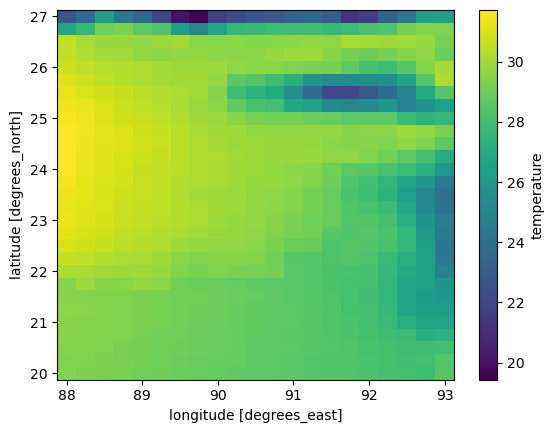

In [14]:
f_new['temperature'][:,:].plot()

In [16]:
f_new.to_netcdf( r'Path to Directory\\ERA5_June_30Mean_Temperature.nc')

In [17]:
import xarray as xr
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin

# Specify the paths to the input NetCDF file and the output GeoTIFF file
netcdf_file = r'Path to Directory\\ERA5_June_30Mean_Temperature.nc'
geotiff_file = r'Path to Directory\\ERA5_June_30Mean_Temperature.tif'

# Open the NetCDF file using xarray
ds = xr.open_dataset(netcdf_file)

# Read the desired variable from the NetCDF file
variable = ds['temperature']

# Get the spatial dimensions (longitude and latitude)
lon = ds['longitude'].values
lat = ds['latitude'].values

# Get the resolution (pixel size) of the grid
resolution_lon = lon[1] - lon[0]
resolution_lat = lat[1] - lat[0]

# Define the spatial extent
left = lon[0]
top = lat[-1]
right = lon[-1]
bottom = lat[0]

# Define the number of pixels in each dimension
width = len(lon)
height = len(lat)

# Define the WGS 84 coordinate system
crs_wgs84 = CRS.from_epsg(4326)

# Create the GeoTIFF file using rasterio
with rasterio.open(
    geotiff_file,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=variable.dtype,
    crs=crs_wgs84,
    transform=from_origin(left, top, resolution_lon, resolution_lat)
) as dst:
    dst.write(variable.values, 1)

# Print the coordinate system information
print("Coordinate System:", crs_wgs84)


Coordinate System: EPSG:4326
